In [1]:
from pathlib import Path
from math import sqrt
import random

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

In [2]:
def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q

In [3]:
train_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_test.csv'), delimiter=',')

In [4]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

### Define functions

In [5]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [199]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        x = V @ y_batch[i]
        dLdx = 2 * (x - x_batch[i])
        dV += np.outer(dLdx, y_batch[i])

        y = softmax(W @ x_batch[i] + b)
        dLdy = y - y_batch[i]
        dW += np.outer(dLdy, x_batch[i])
        db += dLdy

    return (dV, dW, db)


class Perceptron:
    def __init__(self, nIn: int, nOut: int) -> None:
        self.nIn = nIn
        self.nOut = nOut

        self.V: np.ndarray = np.random.uniform(-1, 1, (nIn, nOut))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x: np.ndarray, n_iter: int = 8) -> np.ndarray:
        z = np.zeros(self.nOut)
        y = softmax(self.W @ x + self.b)

        for i in range(n_iter):
            s = mcosim(self.V.T, x)
            z = y * s**3
            x = 0.8 * x + 0.2 * self.V @ z
            # x = (x - np.min(x)) / (np.max(x) - np.min(x))
            y = softmax(self.W @ x + self.b)

        return z

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dV, dW, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.V, self.W, self.b)

                self.V -= lr * dV
                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [200]:
nIn = 784
nOut = 10

learning_rate = 1e-2
max_epoch = 10
batch_size = 128

model = Perceptron(nIn, nOut)

# print('trained loss: ', model.loss(x_test, y_test).round(5))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(x_test, y_test).round(5))

trained loss:  0.06491


In [291]:
n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x, 1)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = round(n_true_pos / x_test.shape[0] * 100, 2)
print(f"test set accuracy: {accuracy}%")

test set accuracy: 90.63%


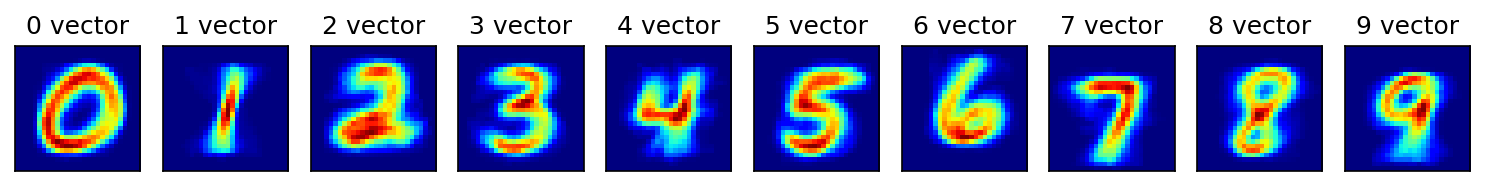

In [292]:
fig, axes = plt.subplots(nrows=1, ncols=10)
fig.set_figwidth(10)
fig.set_figheight(5)
fig.set_dpi(150)

for i, ax in enumerate(axes.ravel()):
    img = ax.imshow(model.V.T[i].reshape((28, 28)), cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{i} vector')

plt.tight_layout()
plt.show()

In [430]:
q = []

idx = random.randint(0, 10000)
# idx = 119
print(idx, np.argmax(y_test[idx]))

x = x_test[idx]
# x = x_test[idx] + np.random.uniform(0.0, 0.25, 784)
q.append(x)

for i in range(16):
    y = softmax(model.W @ x + model.b)
    s = mcosim(model.V.T, x)
    z = y * s**3
    x = 0.8 * x + 0.2 * model.V @ z

    q.append(x)
    print(np.round(z, 2), np.argmax(y), np.argmax(s), np.argmax(z))

2797 5
[0.   0.   0.   0.   0.   0.04 0.   0.15 0.   0.03] 7 5 7
[0.   0.   0.   0.   0.   0.05 0.   0.15 0.   0.03] 7 5 7
[0.   0.   0.   0.   0.   0.06 0.   0.17 0.   0.04] 7 9 7
[0.   0.   0.   0.   0.   0.08 0.   0.19 0.   0.04] 7 9 7
[0.   0.   0.   0.   0.   0.09 0.   0.21 0.   0.04] 7 9 7
[0.   0.   0.   0.   0.   0.11 0.   0.25 0.   0.05] 7 9 7
[0.   0.   0.   0.01 0.   0.12 0.   0.31 0.   0.06] 7 9 7
[0.   0.   0.   0.01 0.   0.11 0.   0.39 0.   0.07] 7 9 7
[0.   0.   0.   0.01 0.   0.09 0.   0.49 0.   0.08] 7 9 7
[0.   0.   0.   0.01 0.   0.05 0.   0.62 0.   0.08] 7 7 7
[0.   0.   0.   0.01 0.   0.02 0.   0.76 0.   0.06] 7 7 7
[0.   0.   0.   0.   0.   0.   0.   0.86 0.   0.04] 7 7 7
[0.   0.   0.   0.   0.   0.   0.   0.92 0.   0.02] 7 7 7
[0.   0.   0.   0.   0.   0.   0.   0.95 0.   0.01] 7 7 7
[0.   0.   0.   0.   0.   0.   0.   0.97 0.   0.01] 7 7 7
[0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.01] 7 7 7


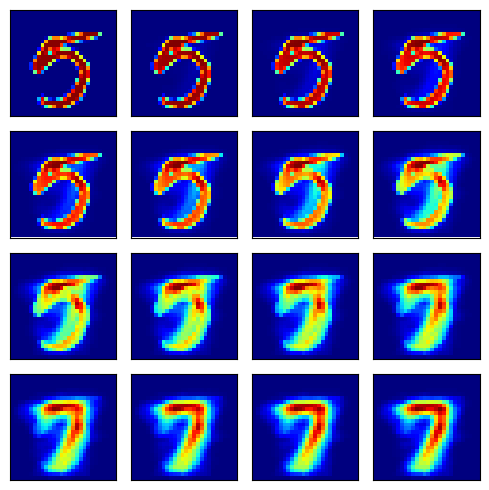

In [431]:
fig, axes = plt.subplots(nrows=4, ncols=4)
fig.set_figwidth(5)
fig.set_figheight(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(q[i].reshape((28, 28)), cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()